# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

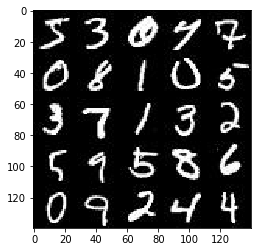

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

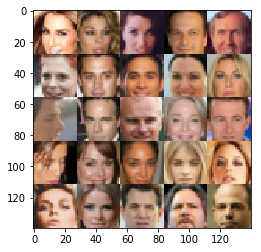

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\Users\Pitto\Anaconda3\envs\tensorflow1_1\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        relu1 = tf.maximum(alpha * x1, x1)
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        strt = 7
        st_filt = 512 
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding="SAME")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding="SAME")
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    d_out_real,d_logits_real = discriminator(input_real, False)
    g_model = generator(input_z, out_channel_dim)
    d_out_fake,d_logits_fake = discriminator(g_model, True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    b,x,y,c=data_shape
    input_real, input_z, _ = model_inputs(x, y, c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, c)
    d_train_opt , g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            ii = 0
            for batch_images in get_batches(batch_size):
                ii = ii+1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                if ii % 10 == 0 : 
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                if ii % 100 == 0 : 
                    show_generator_output(sess, 25, input_z, c, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7284... Generator Loss: 0.4341
Epoch 1/2... Discriminator Loss: 2.0316... Generator Loss: 0.2711
Epoch 1/2... Discriminator Loss: 2.0055... Generator Loss: 0.4550
Epoch 1/2... Discriminator Loss: 1.6306... Generator Loss: 0.9062
Epoch 1/2... Discriminator Loss: 1.0704... Generator Loss: 1.2127
Epoch 1/2... Discriminator Loss: 1.8716... Generator Loss: 0.3175
Epoch 1/2... Discriminator Loss: 1.2958... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 1.5685
Epoch 1/2... Discriminator Loss: 1.2246... Generator Loss: 1.0371
Epoch 1/2... Discriminator Loss: 1.6435... Generator Loss: 0.3899


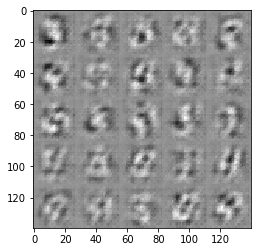

Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.5215
Epoch 1/2... Discriminator Loss: 1.2871... Generator Loss: 0.6568
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 0.8767
Epoch 1/2... Discriminator Loss: 1.5823... Generator Loss: 1.9378
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 1.5061
Epoch 1/2... Discriminator Loss: 1.1200... Generator Loss: 0.9857
Epoch 1/2... Discriminator Loss: 1.0633... Generator Loss: 1.1966
Epoch 1/2... Discriminator Loss: 1.0502... Generator Loss: 1.2046
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.5678
Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 1.1640


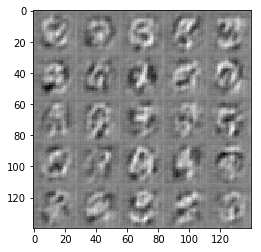

Epoch 1/2... Discriminator Loss: 1.1205... Generator Loss: 1.7705
Epoch 1/2... Discriminator Loss: 1.1163... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 1.2503... Generator Loss: 2.0858
Epoch 1/2... Discriminator Loss: 1.4284... Generator Loss: 0.5292
Epoch 1/2... Discriminator Loss: 1.0620... Generator Loss: 0.9121
Epoch 1/2... Discriminator Loss: 0.8923... Generator Loss: 1.3445
Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 0.9571
Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 0.5335
Epoch 1/2... Discriminator Loss: 1.5606... Generator Loss: 0.4235
Epoch 1/2... Discriminator Loss: 0.9942... Generator Loss: 1.2764


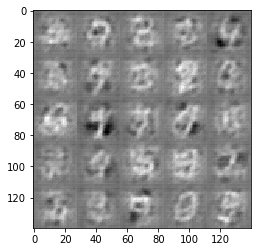

Epoch 1/2... Discriminator Loss: 0.9972... Generator Loss: 0.9222
Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 0.6029
Epoch 1/2... Discriminator Loss: 0.9922... Generator Loss: 1.4401
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 1.7634
Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 1.3369
Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 0.7789
Epoch 1/2... Discriminator Loss: 1.2527... Generator Loss: 0.6788
Epoch 1/2... Discriminator Loss: 1.0038... Generator Loss: 1.0238
Epoch 1/2... Discriminator Loss: 0.9951... Generator Loss: 1.1517
Epoch 1/2... Discriminator Loss: 1.7131... Generator Loss: 0.3962


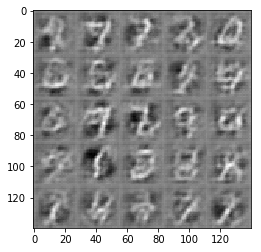

Epoch 1/2... Discriminator Loss: 1.1432... Generator Loss: 0.7280
Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 1.0403
Epoch 1/2... Discriminator Loss: 1.3349... Generator Loss: 0.5876
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.7737
Epoch 1/2... Discriminator Loss: 1.0260... Generator Loss: 1.3777
Epoch 1/2... Discriminator Loss: 1.2713... Generator Loss: 0.6366
Epoch 1/2... Discriminator Loss: 1.1015... Generator Loss: 0.7791
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.7494
Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 1.4183
Epoch 1/2... Discriminator Loss: 1.0739... Generator Loss: 1.1289


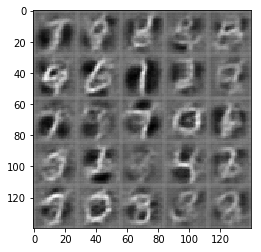

Epoch 1/2... Discriminator Loss: 1.1704... Generator Loss: 1.0818
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 0.7011
Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 0.9776
Epoch 1/2... Discriminator Loss: 1.1145... Generator Loss: 0.8480
Epoch 1/2... Discriminator Loss: 1.0624... Generator Loss: 1.0385
Epoch 1/2... Discriminator Loss: 1.1943... Generator Loss: 0.7451
Epoch 1/2... Discriminator Loss: 1.4858... Generator Loss: 0.4814
Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 0.9188... Generator Loss: 1.3563
Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 1.1642


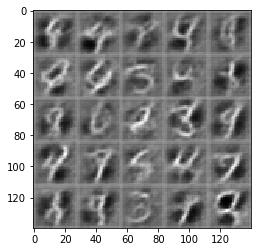

Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 0.7891
Epoch 1/2... Discriminator Loss: 1.5584... Generator Loss: 0.4273
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.8082
Epoch 1/2... Discriminator Loss: 1.0019... Generator Loss: 1.0864
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 1.3304
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.5964
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 0.9349
Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 1.6415
Epoch 1/2... Discriminator Loss: 1.2525... Generator Loss: 0.6470
Epoch 1/2... Discriminator Loss: 1.1146... Generator Loss: 1.1770


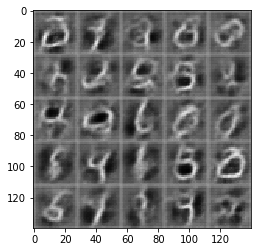

Epoch 1/2... Discriminator Loss: 1.5040... Generator Loss: 2.2104
Epoch 1/2... Discriminator Loss: 1.1500... Generator Loss: 1.0513
Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 1.2286
Epoch 1/2... Discriminator Loss: 0.9877... Generator Loss: 1.4569
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.5588
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 1.1622
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 1.0145
Epoch 1/2... Discriminator Loss: 2.2227... Generator Loss: 0.2601
Epoch 1/2... Discriminator Loss: 1.1815... Generator Loss: 0.8751
Epoch 1/2... Discriminator Loss: 1.1976... Generator Loss: 0.7093


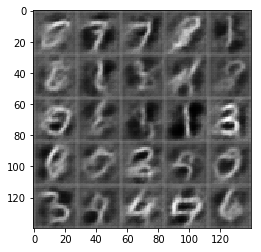

Epoch 1/2... Discriminator Loss: 0.9668... Generator Loss: 1.2910
Epoch 1/2... Discriminator Loss: 0.9596... Generator Loss: 1.4072
Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 1.4462
Epoch 1/2... Discriminator Loss: 1.0465... Generator Loss: 0.8388
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 1.1399
Epoch 1/2... Discriminator Loss: 1.5712... Generator Loss: 0.4895
Epoch 1/2... Discriminator Loss: 1.1376... Generator Loss: 1.4726
Epoch 1/2... Discriminator Loss: 1.1052... Generator Loss: 0.9435
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 0.9159
Epoch 1/2... Discriminator Loss: 1.0829... Generator Loss: 0.8446


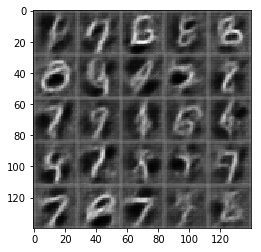

Epoch 1/2... Discriminator Loss: 2.1407... Generator Loss: 0.2564
Epoch 1/2... Discriminator Loss: 1.0088... Generator Loss: 0.9902
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 0.7234
Epoch 2/2... Discriminator Loss: 0.9119... Generator Loss: 1.2033
Epoch 2/2... Discriminator Loss: 1.2325... Generator Loss: 0.6442
Epoch 2/2... Discriminator Loss: 1.1661... Generator Loss: 0.9653
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 1.0877
Epoch 2/2... Discriminator Loss: 1.0280... Generator Loss: 1.0766
Epoch 2/2... Discriminator Loss: 1.7649... Generator Loss: 1.8499
Epoch 2/2... Discriminator Loss: 1.1343... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 0.9617
Epoch 2/2... Discriminator Loss: 0.9374... Generator Loss: 1.1065
Epoch 2/2... Discriminator Loss: 1.0122... Generator Loss: 1.0139


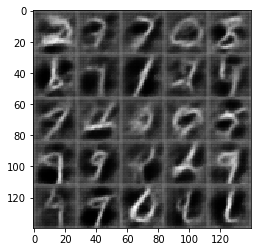

Epoch 2/2... Discriminator Loss: 0.9626... Generator Loss: 1.0187
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 1.4667
Epoch 2/2... Discriminator Loss: 0.9199... Generator Loss: 1.2057
Epoch 2/2... Discriminator Loss: 0.9415... Generator Loss: 1.3262
Epoch 2/2... Discriminator Loss: 1.0779... Generator Loss: 0.7765
Epoch 2/2... Discriminator Loss: 1.0613... Generator Loss: 0.7664
Epoch 2/2... Discriminator Loss: 1.2461... Generator Loss: 1.0363
Epoch 2/2... Discriminator Loss: 1.0993... Generator Loss: 1.1196
Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 0.9042
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 1.1678


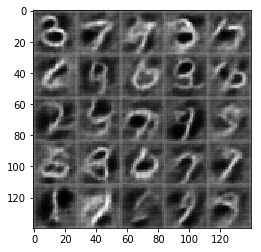

Epoch 2/2... Discriminator Loss: 0.8772... Generator Loss: 1.3654
Epoch 2/2... Discriminator Loss: 1.0086... Generator Loss: 0.9953
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 1.0999
Epoch 2/2... Discriminator Loss: 1.1552... Generator Loss: 0.7866
Epoch 2/2... Discriminator Loss: 0.8685... Generator Loss: 1.1032
Epoch 2/2... Discriminator Loss: 1.0804... Generator Loss: 0.8428
Epoch 2/2... Discriminator Loss: 1.0248... Generator Loss: 1.3061
Epoch 2/2... Discriminator Loss: 1.0814... Generator Loss: 0.8923
Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 0.9419... Generator Loss: 1.2565


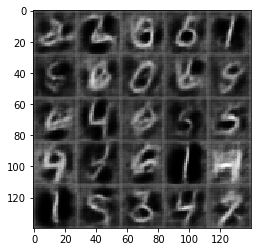

Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 1.3231
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.6379
Epoch 2/2... Discriminator Loss: 0.9170... Generator Loss: 1.6280
Epoch 2/2... Discriminator Loss: 0.8957... Generator Loss: 1.1148
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 1.3631
Epoch 2/2... Discriminator Loss: 1.1133... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.1796... Generator Loss: 0.6661
Epoch 2/2... Discriminator Loss: 0.6958... Generator Loss: 1.7910
Epoch 2/2... Discriminator Loss: 1.9430... Generator Loss: 2.8969
Epoch 2/2... Discriminator Loss: 1.2402... Generator Loss: 0.6646


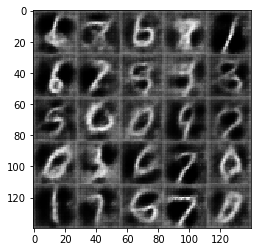

Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 1.6110
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 1.5020
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 1.7007
Epoch 2/2... Discriminator Loss: 0.9505... Generator Loss: 0.9788
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 0.9298
Epoch 2/2... Discriminator Loss: 0.9695... Generator Loss: 0.9424
Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.6357
Epoch 2/2... Discriminator Loss: 0.9967... Generator Loss: 1.0664
Epoch 2/2... Discriminator Loss: 1.2142... Generator Loss: 0.6455
Epoch 2/2... Discriminator Loss: 0.9362... Generator Loss: 1.0039


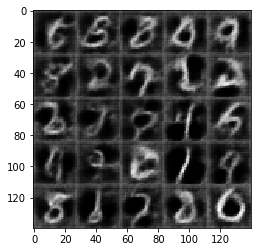

Epoch 2/2... Discriminator Loss: 0.9666... Generator Loss: 1.0838
Epoch 2/2... Discriminator Loss: 0.8169... Generator Loss: 1.1903
Epoch 2/2... Discriminator Loss: 1.5908... Generator Loss: 3.0650
Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 0.9747
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 1.9202
Epoch 2/2... Discriminator Loss: 0.9649... Generator Loss: 1.0281
Epoch 2/2... Discriminator Loss: 1.0983... Generator Loss: 0.8163
Epoch 2/2... Discriminator Loss: 0.8276... Generator Loss: 1.4425
Epoch 2/2... Discriminator Loss: 0.8548... Generator Loss: 1.0903
Epoch 2/2... Discriminator Loss: 0.7406... Generator Loss: 1.6918


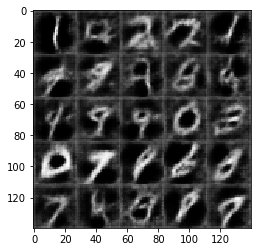

Epoch 2/2... Discriminator Loss: 0.9367... Generator Loss: 1.4779
Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 1.4873
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 1.5079
Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 1.7754
Epoch 2/2... Discriminator Loss: 1.2607... Generator Loss: 0.7537
Epoch 2/2... Discriminator Loss: 1.0248... Generator Loss: 1.0017
Epoch 2/2... Discriminator Loss: 1.1064... Generator Loss: 1.0218
Epoch 2/2... Discriminator Loss: 1.7840... Generator Loss: 0.3431
Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 1.2975
Epoch 2/2... Discriminator Loss: 1.3058... Generator Loss: 0.6074


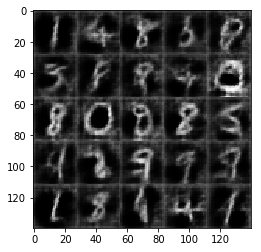

Epoch 2/2... Discriminator Loss: 1.1808... Generator Loss: 0.8997
Epoch 2/2... Discriminator Loss: 1.1072... Generator Loss: 0.8161
Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 1.8158
Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 1.2657
Epoch 2/2... Discriminator Loss: 0.7570... Generator Loss: 1.3905
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 1.2574
Epoch 2/2... Discriminator Loss: 1.4357... Generator Loss: 0.6175
Epoch 2/2... Discriminator Loss: 1.2563... Generator Loss: 0.6630
Epoch 2/2... Discriminator Loss: 1.3235... Generator Loss: 0.6824
Epoch 2/2... Discriminator Loss: 1.2084... Generator Loss: 2.7911


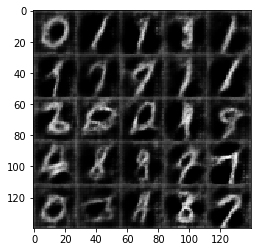

Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 1.0335
Epoch 2/2... Discriminator Loss: 1.0298... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 0.7134... Generator Loss: 1.7489
Epoch 2/2... Discriminator Loss: 0.6336... Generator Loss: 1.9331
Epoch 2/2... Discriminator Loss: 0.8998... Generator Loss: 1.3282
Epoch 2/2... Discriminator Loss: 1.4570... Generator Loss: 0.8138
Epoch 2/2... Discriminator Loss: 1.0299... Generator Loss: 1.0626
Epoch 2/2... Discriminator Loss: 0.8733... Generator Loss: 1.4124
Epoch 2/2... Discriminator Loss: 0.8851... Generator Loss: 1.2404
Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 1.1951


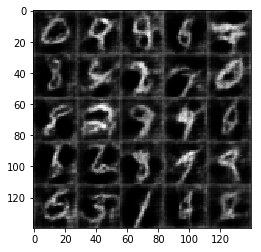

Epoch 2/2... Discriminator Loss: 1.1731... Generator Loss: 0.7584
Epoch 2/2... Discriminator Loss: 0.9214... Generator Loss: 1.5949
Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 0.8834


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 3.5910
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.6711
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 1.3298
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.4634
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 2.2911
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 1.1054


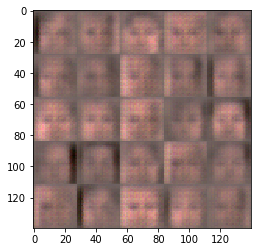

Epoch 1/1... Discriminator Loss: 1.7139... Generator Loss: 0.4211
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 1.0620
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.9935
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 2.0983... Generator Loss: 0.2709
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 1.7323
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.7743


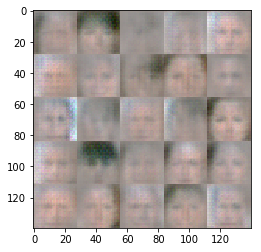

Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.2378
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 1.1085
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.8202... Generator Loss: 2.5927
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 2.1057
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 1.7541
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.1812


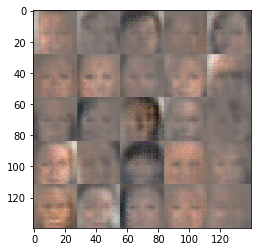

Epoch 1/1... Discriminator Loss: 1.5715... Generator Loss: 0.4470
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 1.3243
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.7924


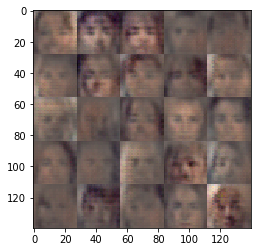

Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 1.1056
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.6852... Generator Loss: 0.3846
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7360


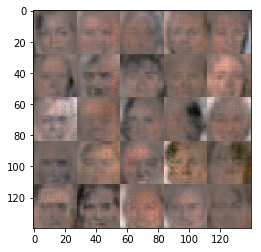

Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 1.4780


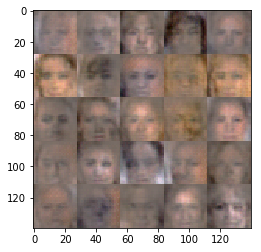

Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 1.0268
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.9992
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.7559


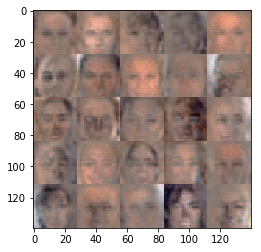

Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.7656


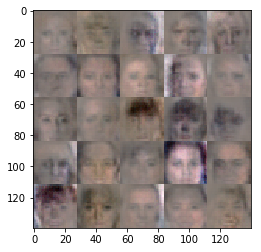

Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 1.2067
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 1.5706
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 1.3530
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.5997


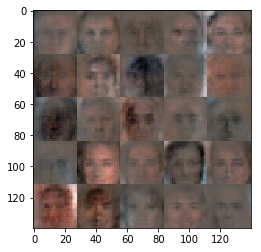

Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.3392
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 1.0788
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 1.3718
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.9580


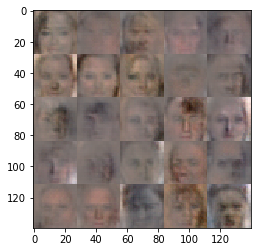

Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 1.1926
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 1.4768
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 1.2016
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 1.7006
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 1.2262
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.8365


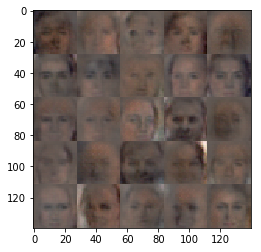

Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.8432


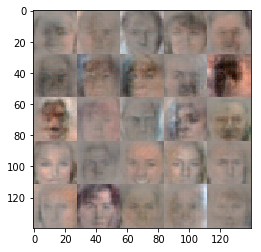

Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.0693
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 1.5835
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.6371


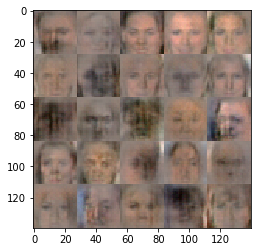

Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 1.2948


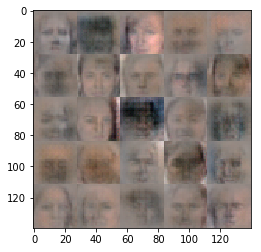

Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.8172


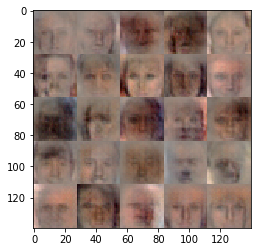

Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 1.1742
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 1.2628
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.8284


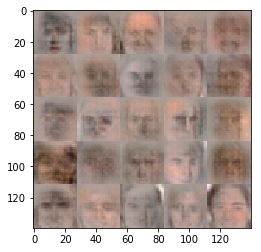

Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 1.2924
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.2271
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.6804


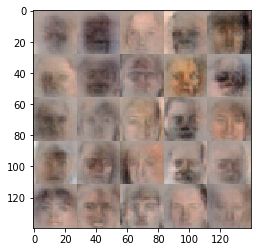

Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 1.3962
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 1.3239
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 1.0618


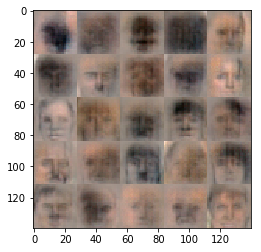

Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.4384
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 1.2583


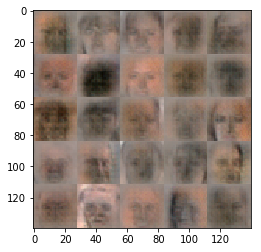

Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.5566
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 1.1429
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 1.3124


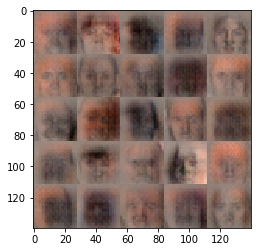

Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 1.4002
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 1.3709
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.1490


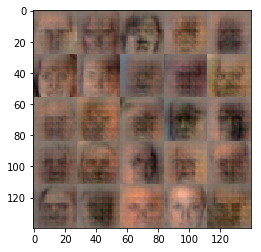

Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 2.0270


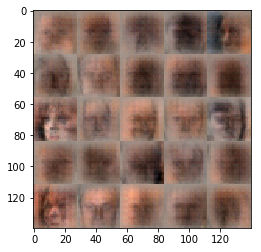

Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 1.1480
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.2362
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 1.6421


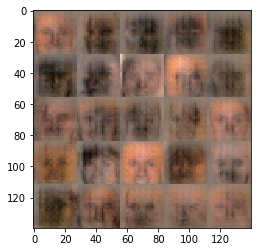

Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 1.2367
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.1164
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.5591


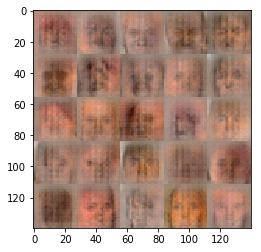

Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 1.2980
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.0770
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 1.7270
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 1.5572
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 1.1117
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 1.2926
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.6075


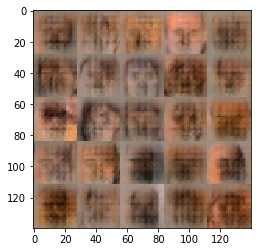

Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.4080
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.6338... Generator Loss: 1.6858
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 1.7001
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.5695
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.8982


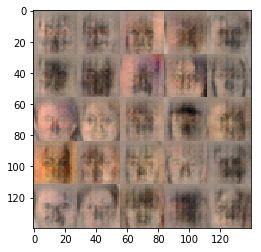

Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 1.4585
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 1.4580
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.2588


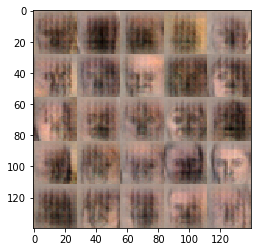

Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.1809
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 1.5870
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.2169
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.0399


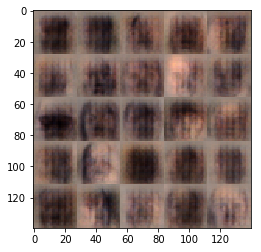

Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 2.0555... Generator Loss: 0.2345
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 1.5355
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.6778


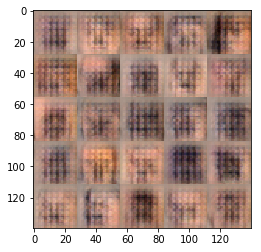

Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 1.4843
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 1.1230
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 1.7732
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.2923
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.4841


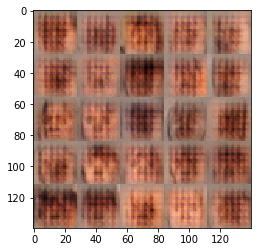

Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 1.2527
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 1.2198
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.2343
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.1115


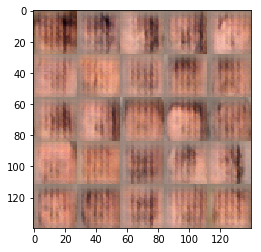

Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 1.9363
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.6282


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.